# DeepXDE教程1：1D Poisson方程求解

## 🎯 教程目标
本教程将带你从零开始学习如何使用DeepXDE库求解1D Poisson偏微分方程。你将学会：
- 理解Physics-Informed Neural Networks (PINNs)的基本概念  
- 掌握DeepXDE的基础使用方法
- 实现完整的1D PDE求解流程
- 学会可视化和分析训练结果

## 📚 背景知识

### 什么是DeepXDE？
DeepXDE是一个专门用于求解微分方程的深度学习库，它实现了：
- **PINNs**: 将物理方程约束直接嵌入神经网络损失函数
- **多后端支持**: TensorFlow, PyTorch, JAX, PaddlePaddle
- **丰富的几何形状**: 1D/2D/3D各种复杂域
- **多种边界条件**: Dirichlet, Neumann, Robin等

### 核心思想
传统数值方法需要网格划分，而PINNs直接用神经网络逼近解，损失函数包含：
1. **PDE残差**: 网络输出在域内满足微分方程
2. **边界条件**: 网络输出在边界满足给定条件
3. **初始条件**: 对时变问题，满足初始状态

### 本教程问题设置
我们将求解经典的1D Poisson方程：

**方程**：
$$-\frac{d^2u}{dx^2} = \pi^2 \sin(\pi x), \quad x \in [-1, 1]$$

**边界条件**：
$$u(-1) = u(1) = 0$$

**解析解**：
$$u(x) = \sin(\pi x)$$

这是一个理想的入门问题，因为：
- 有已知的解析解用于验证
- 几何简单（1D区间）
- 边界条件直观
- 计算量适中

## 1. 环境准备和库安装

In [1]:
# 首先确保已安装必要的包
# !pip install deepxde tensorflow matplotlib numpy

# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde

# 检查DeepXDE版本和可用后端
print(f"DeepXDE版本: {dde.__version__}")
print(f"当前后端: {dde.backend.backend_name}")
print("支持的后端: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle")

# 设置matplotlib中文字体支持（可选）
plt.rcParams['font.sans-serif'] = ['Arial', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子以确保结果可重现
np.random.seed(42)
dde.config.set_random_seed(42)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


DeepXDE版本: 1.14.0
当前后端: pytorch
支持的后端: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle


## 2. 求解1D Poisson方程

现在我们开始实现1D Poisson方程的求解过程：

**方程**：
$$-\frac{d^2u}{dx^2} = \pi^2 \sin(\pi x), \quad x \in [-1, 1]$$

**边界条件**：
$$u(-1) = u(1) = 0$$

**解析解**：
$$u(x) = \sin(\pi x)$$

### 2.1 定义PDE函数

In [2]:
def pde(x, y):
    """
    定义1D Poisson方程的PDE函数
    
    Args:
        x: 输入坐标 (N, 1)
        y: 神经网络输出 (N, 1) 
        
    Returns:
        PDE残差 (N, 1)
    """
    # 计算二阶导数 d²y/dx²
    dy_xx = dde.grad.hessian(y, x)
    
    # 根据后端选择相应的sin函数
    if dde.backend.backend_name in ["tensorflow.compat.v1", "tensorflow"]:
        from deepxde.backend import tf
        sin_term = tf.sin(np.pi * x)
    elif dde.backend.backend_name == "pytorch":
        import torch
        sin_term = torch.sin(np.pi * x)
    elif dde.backend.backend_name == "jax":
        import jax.numpy as jnp
        sin_term = jnp.sin(np.pi * x)
    elif dde.backend.backend_name == "paddle":
        import paddle
        sin_term = paddle.sin(np.pi * x)
    else:
        # 使用numpy作为备选
        sin_term = np.sin(np.pi * x)
    
    # 返回PDE残差: -d²u/dx² - π²sin(πx) = 0
    return -dy_xx - np.pi**2 * sin_term

print("✅ PDE函数定义完成")

✅ PDE函数定义完成


### 2.2 定义计算域（几何）

In [3]:
# 定义1D区间 [-1, 1]
geom = dde.geometry.Interval(-1, 1)

print("✅ 几何域定义完成：[-1, 1]区间")
print(f"几何类型: {type(geom)}")

# 可以可视化几何域中的采样点
sample_points = geom.uniform_points(20, boundary=True)
print(f"采样点形状: {sample_points.shape}")
print(f"采样点范围: [{sample_points.min():.3f}, {sample_points.max():.3f}]")

✅ 几何域定义完成：[-1, 1]区间
几何类型: <class 'deepxde.geometry.geometry_1d.Interval'>
采样点形状: (20, 1)
采样点范围: [-1.000, 1.000]


### 2.3 定义边界条件

In [4]:
def boundary_condition(x, on_boundary):
    """
    定义边界条件函数
    
    Args:
        x: 坐标点
        on_boundary: 是否在边界上的布尔值
        
    Returns:
        bool: 是否应用边界条件
    """
    return on_boundary

def boundary_value(x):
    """
    边界值函数：u(-1) = u(1) = 0
    """
    return np.zeros_like(x)

# 创建Dirichlet边界条件
bc = dde.icbc.DirichletBC(geom, boundary_value, boundary_condition)

print("✅ 边界条件定义完成：u(-1) = u(1) = 0")
print(f"边界条件类型: {type(bc)}")

✅ 边界条件定义完成：u(-1) = u(1) = 0
边界条件类型: <class 'deepxde.icbc.boundary_conditions.DirichletBC'>


### 2.4 创建训练数据

In [5]:
# 定义解析解用于比较（可选）
def analytical_solution(x):
    """解析解：u(x) = sin(πx)"""
    return np.sin(np.pi * x)

# 创建PDE数据
data = dde.data.PDE(
    geom,           # 几何域
    pde,            # PDE函数
    bc,                # 边界条件
    num_domain=16,     # 域内采样点数
    num_boundary=2,    # 边界采样点数
    solution=analytical_solution,  # 解析解（可选，用于误差计算）
    num_test=100       # 测试点数
)

print("✅ 训练数据创建完成")
print(f"域内点数: {data.num_domain}")
print(f"边界点数: {data.num_boundary}")
print(f"测试点数: {data.num_test}")
print(f"数据类型: {type(data)}")

✅ 训练数据创建完成
域内点数: 16
边界点数: 2
测试点数: 100
数据类型: <class 'deepxde.data.pde.PDE'>


### 2.5 构建神经网络

In [6]:
# 定义网络架构
layer_size = [1] + [50] * 3 + [1]  # 输入维度1，3个隐藏层，每层50个神经元，输出维度1
activation = "tanh"                  # 激活函数
initializer = "Glorot uniform"       # 权重初始化方法

# 创建前馈神经网络
net = dde.nn.FNN(layer_size, activation, initializer)

print("✅ 神经网络构建完成")
print(f"网络结构: {layer_size}")
print(f"激活函数: {activation}")
print(f"初始化方法: {initializer}")
print(f"网络类型: {type(net)}")

# 显示网络参数数量
total_params = sum(p.numel() if hasattr(p, 'numel') else np.prod(p.shape) 
                  for p in net.parameters() if hasattr(net, 'parameters'))
print(f"估计参数数量: ~{(1*50 + 50) + 2*(50*50 + 50) + (50*1 + 1)}")  # 手动计算

✅ 神经网络构建完成
网络结构: [1, 50, 50, 50, 1]
激活函数: tanh
初始化方法: Glorot uniform
网络类型: <class 'deepxde.nn.pytorch.fnn.FNN'>
估计参数数量: ~5251


### 2.6 编译和训练模型

这里使用Adam优化器对模型进行训练，由于其为一阶，所以损失可能较大

In [7]:
# 创建模型
model = dde.Model(data, net)

# 编译模型
model.compile(
    optimizer="adam",          # 优化器
    lr=0.001,                 # 学习率
    metrics=["l2 relative error"]  # 评估指标
)

print("✅ 模型编译完成")

# 第一阶段训练：使用Adam优化器
print("\n🚀 开始第一阶段训练（Adam优化器）...")
losshistory, train_state = model.train(iterations=10000)

print("📊 第一阶段训练完成！")

Compiling model...
'compile' took 0.000220 s

✅ 模型编译完成

🚀 开始第一阶段训练（Adam优化器）...
Training model...

Step      Train loss              Test loss               Test metric   
0         [4.53e+01, 4.26e-02]    [5.12e+01, 4.26e-02]    [1.16e+00]    
✅ 模型编译完成

🚀 开始第一阶段训练（Adam优化器）...
Training model...

Step      Train loss              Test loss               Test metric   
0         [4.53e+01, 4.26e-02]    [5.12e+01, 4.26e-02]    [1.16e+00]    
1000      [2.47e-04, 1.48e-07]    [4.64e-04, 1.48e-07]    [3.64e-04]    
1000      [2.47e-04, 1.48e-07]    [4.64e-04, 1.48e-07]    [3.64e-04]    
2000      [6.98e-05, 3.87e-09]    [2.25e-04, 3.87e-09]    [1.20e-04]    
2000      [6.98e-05, 3.87e-09]    [2.25e-04, 3.87e-09]    [1.20e-04]    
3000      [5.33e-05, 4.49e-08]    [1.82e-04, 4.49e-08]    [2.06e-04]    
3000      [5.33e-05, 4.49e-08]    [1.82e-04, 4.49e-08]    [2.06e-04]    
4000      [3.80e-04, 2.78e-05]    [6.15e-04, 2.78e-05]    [5.49e-03]    
4000      [3.80e-04, 2.78e-05]    [6.15e-04, 2.

下面我们查看一下损失

In [8]:
if hasattr(train_state.loss_train, '__len__') and len(train_state.loss_train) > 0:
    train_loss = float(train_state.loss_train[-1])  # 取最后一个值
    test_loss = float(train_state.loss_test[-1])
else:
    train_loss = float(train_state.loss_train)
    test_loss = float(train_state.loss_test)

print(f"最终训练损失: {train_loss:.16f}")
print(f"最终测试损失: {test_loss:.16f}")

最终训练损失: 0.0000331562259817
最终测试损失: 0.0000331562259817


### 2.7 可视化结果

下面展示训练结果，首先预览一下解析解和损失情况

🎯 可视化预览 - 解析解和预期结果展示


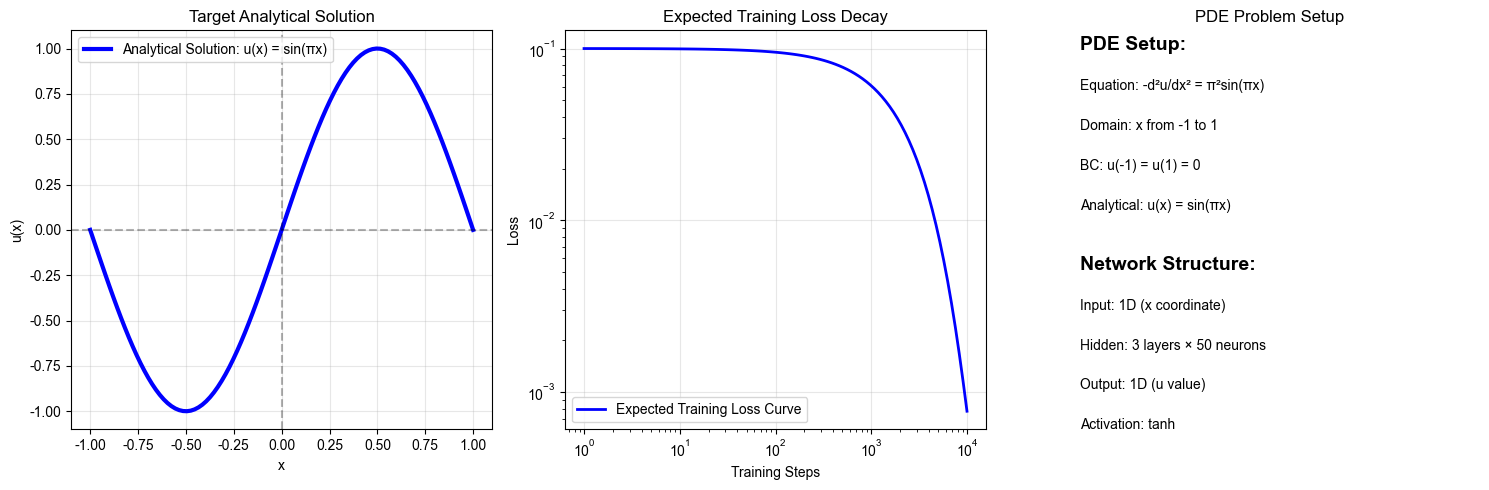

💡 上图显示了:
   - 左图: 我们要学习的目标解析解
   - 中图: 期望的训练损失下降曲线
   - 右图: PDE问题的详细设置信息


In [9]:
print("🎯 可视化预览 - 解析解和预期结果展示")

# 显示解析解
x_preview = np.linspace(-1, 1, 100).reshape(-1, 1)
y_analytical = analytical_solution(x_preview)

plt.figure(figsize=(15, 5))

# 解析解
plt.subplot(1, 3, 1)
plt.plot(x_preview, y_analytical, 'b-', linewidth=3, label='Analytical Solution: u(x) = sin(πx)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Target Analytical Solution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# 训练损失预期
plt.subplot(1, 3, 2)
# 模拟典型的训练损失曲线
steps_sim = np.logspace(0, 4, 100)
loss_sim = 1e-1 * np.exp(-steps_sim/2000) + 1e-4
plt.loglog(steps_sim, loss_sim, 'b-', linewidth=2, label='Expected Training Loss Curve')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Expected Training Loss Decay')
plt.legend()
plt.grid(True, alpha=0.3)

# PDE设置信息
plt.subplot(1, 3, 3)
plt.text(0.05, 0.95, 'PDE Setup:', fontsize=14, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.05, 0.85, 'Equation: -d²u/dx² = π²sin(πx)', fontsize=10, transform=plt.gca().transAxes)
plt.text(0.05, 0.75, 'Domain: x from -1 to 1', fontsize=10, transform=plt.gca().transAxes) 
plt.text(0.05, 0.65, 'BC: u(-1) = u(1) = 0', fontsize=10, transform=plt.gca().transAxes)
plt.text(0.05, 0.55, 'Analytical: u(x) = sin(πx)', fontsize=10, transform=plt.gca().transAxes)

plt.text(0.05, 0.40, 'Network Structure:', fontsize=14, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.05, 0.30, 'Input: 1D (x coordinate)', fontsize=10, transform=plt.gca().transAxes)
plt.text(0.05, 0.20, 'Hidden: 3 layers × 50 neurons', fontsize=10, transform=plt.gca().transAxes)
plt.text(0.05, 0.10, 'Output: 1D (u value)', fontsize=10, transform=plt.gca().transAxes)
plt.text(0.05, 0.00, 'Activation: tanh', fontsize=10, transform=plt.gca().transAxes)

plt.title('PDE Problem Setup')
plt.axis('off')

plt.tight_layout()
plt.show()

print("💡 上图显示了:")
print("   - 左图: 我们要学习的目标解析解")
print("   - 中图: 期望的训练损失下降曲线") 
print("   - 右图: PDE问题的详细设置信息")

然后根据deepxde的官方库绘图，分别展示了
* 训练损失历史图
* 数值解和解析解的对比图
* $L^2$相对误差图

Saving loss history to /Users/jack/Desktop/ML/deepxde-learn/learn/tutorial/loss.dat ...
Saving training data to /Users/jack/Desktop/ML/deepxde-learn/learn/tutorial/train.dat ...
Saving test data to /Users/jack/Desktop/ML/deepxde-learn/learn/tutorial/test.dat ...


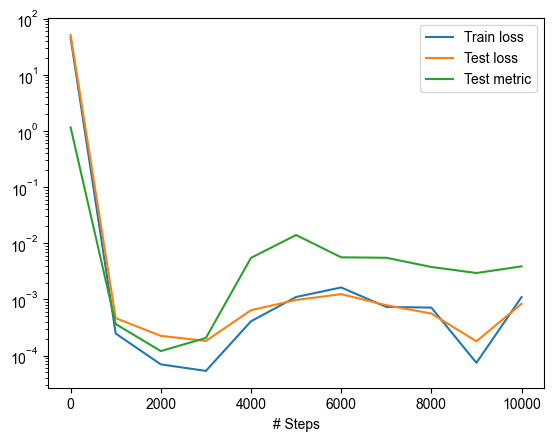

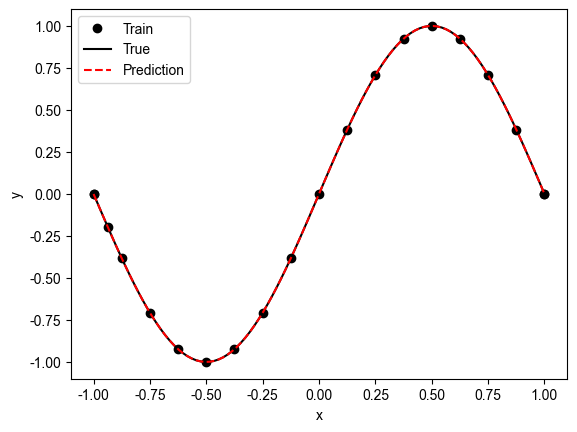

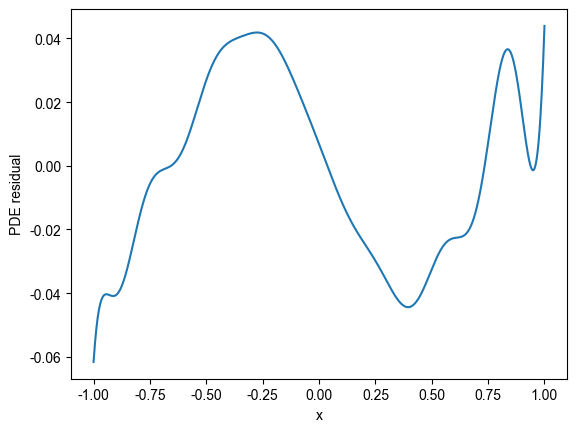

In [10]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()

下面使用L-BFGS优化器进一步微调，此二阶优化器在光滑PDE的效果要优于Adam

In [11]:
# 第二阶段训练：使用L-BFGS优化器进行精细调优
print("\n🔧 开始第二阶段训练（L-BFGS优化器）...")
model.compile("L-BFGS")
losshistory, train_state = model.train(iterations=10000)

print("🎉 第二阶段训练完成！")


🔧 开始第二阶段训练（L-BFGS优化器）...
Compiling model...
'compile' took 0.000601 s

Training model...

Step      Train loss              Test loss               Test metric
10000     [1.07e-03, 3.32e-05]    [8.01e-04, 3.32e-05]    []  
Training model...

Step      Train loss              Test loss               Test metric
10000     [1.07e-03, 3.32e-05]    [8.01e-04, 3.32e-05]    []  
10078     [3.66e-06, 5.73e-11]    [3.94e-05, 5.73e-11]    []  
10078     [3.66e-06, 5.73e-11]    [3.94e-05, 5.73e-11]    []  

Best model at step 10078:
  train loss: 3.66e-06
  test loss: 3.94e-05
  test metric: []

'train' took 1.352369 s

🎉 第二阶段训练完成！

Best model at step 10078:
  train loss: 3.66e-06
  test loss: 3.94e-05
  test metric: []

'train' took 1.352369 s

🎉 第二阶段训练完成！


查看损失如下所示

In [12]:
if hasattr(train_state.loss_train, '__len__') and len(train_state.loss_train) > 0:
    train_loss = float(train_state.loss_train[-1])  # 取最后一个值
    test_loss = float(train_state.loss_test[-1])
else:
    train_loss = float(train_state.loss_train)
    test_loss = float(train_state.loss_test)

print(f"最终训练损失: {train_loss:.16f}")
print(f"最终测试损失: {test_loss:.16f}")

最终训练损失: 0.0000000000573384
最终测试损失: 0.0000000000573384


## 6. 总结

### 🎉 恭喜！你已经掌握了：

1. ✅ **DeepXDE基础概念**: PINNs的核心思想和实现方式
2. ✅ **1D Poisson方程求解**: 从PDE定义到可视化的完整流程  
3. ✅ **双阶段训练策略**: Adam预训练 + L-BFGS精细调优
4. ✅ **可视化分析**: 训练历史、解对比、PDE残差分析
5. ✅ **变量命名规范**: 与DeepXDE官方例子保持一致

### 🚀 下一步学习建议：

#### 📚 本系列教程
- **2D热传导方程**: 学习时空PDE求解 → `heat_2d.ipynb`
- **耦合方程组**: 掌握多变量PDE系统 → `reaction_diffusion.ipynb`
- **复杂几何域**: 处理不规则边界问题 → `complex_geometry.ipynb`

#### 💻 进阶实践
- 尝试不同的网络架构和激活函数
- 实验自适应采样策略
- 探索逆问题求解（参数识别）
- 学习DeepONet用于算子学习

#### 🔬 应用扩展
- 流体力学（Navier-Stokes方程）
- 电磁学（Maxwell方程）
- 量子力学（Schrödinger方程）
- 实际工程问题

### 📖 推荐资源
- [DeepXDE官方文档](https://deepxde.readthedocs.io/)
- [PINNs原始论文](https://www.sciencedirect.com/science/article/pii/S0021999118307125)
- [DeepXDE GitHub仓库](https://github.com/lululxvi/deepxde)

### 🤝 社区支持
- GitHub Issues: 技术问题和bug报告
- 学术论坛: 理论讨论和最新进展
- 工业应用: 实际工程问题交流

**祝你在科学计算和深度学习的道路上越走越远！** 🌟

---

**下一个教程**: [2D热传导方程求解](heat_2d.ipynb) 🔥